# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework 11
**Harvard University**<br>
**Spring 2017**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Monday, April 23rd, 2018 at 11:59pm

**Instructions:**

- Upload your final answers as an iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## The AM207 Cambridge Nursery

A plant nursery in Cambridge is exprimentally cross-breeding two types of hibiscus flowers: blue and pink. The goal is to create an exotic flower whose petals are pink with a ring of blue on each. 

There are four types of child plant that can result from this cross-breeding: 

  - Type 1: blue petals
  - Type 2: pink petals 
  - Type 3: purple petals
  - Type 4: pink petals with a blue ring on each (the desired effect). 

Out of 197 initial cross-breedings, the nursery obtained the following distribution over the four types of child plants: 
$$Y = (y_1, y_2, y_3, y_4) = (125, 18, 20, 34)$$
where $y_i$ represents the number of child plants that are of type $i$.

The nursery then consulted a famed Harvard plant geneticist, who informed them that the probability of obtaining each type of child plant in any single breeding experiment is as follows:
$$ \frac{\theta+2}{4}, \frac{1-\theta}{4}, \frac{1-\theta}{4}, \frac{\theta}{4}.$$
Unfortunately, the geneticist did not specify the quantity $\theta$.

Clearly, the nursery is interested in understanding how many cross-breeding they must perform, on average, in order to obtain a certain number of child plants with the exotic blue rings. To do this they must be able to compute $\theta$. 

The owners of the nursery, being top students in AM207, decided to model the experiment in hopes of discovering $\theta$ using the results from their 197 initial experiments. 

They chose to model the observed data using a multinomial model and thus calculated the likelihood to be:
$$ p(y  \vert  \theta) \propto (2+\theta)^{y_1} (1-\theta)^{y_2+y_3}  \, \theta^{y_4}
$$

Being good Bayesians, they also imposed a prior on $\theta$, $\rm{Beta}(a, b)$.

Thus, the posterior is:
$$ p(\theta \vert  Y) = \left( 2+\theta \right)^{y_1} (1-\theta)^{y_2+y_3} \, \theta^{
y_4} \, \theta^{a-1} \, (1-\theta)^{b-1}. $$

If the nursery owners are able to sample from the posterior, they would be able to understand the distribution of $\theta$ and make appropriate estimates.

## Problem 1. Sampling using data augmentation

Realizing that it would be difficult to sample from the posterior directly and after being repeatedly frustrated by attempts of Metropolis-Hastings and Gibbs sampling for this model, the nursery owners decided to augment their model and hopefully obtain a friendlier looking distribution that allows for easy sampling.

They augment the data with a new variable $z$ such that:
$$z + (y_1 - z) = y_1.$$
That is, using $z$, we are breaking $y_1$, the number of type I child plants, into two subtypes. Let the probability of obtaining the two subtype be $1/2$ and $\theta/4$, respectively. Now, we can interpret $y_1$ to be the total number of trials in a binomial trial. Thus, the new likelihood can be written as
$$ p(y, z  \vert  \theta) \propto \binom{y_{1}}{z} \left (\frac{1}{2} \right )^{y_1-z} \left(\frac{\theta}{4} \right )^{z}  (1-\theta)^{y_2+y_3}  \, \theta^{y_4}
$$


Derive the joint posterior $p(\theta, z  \vert  y)$ and sample from it using Gibbs sampling.

Visualize the distribution of theta and, from this distribution, estimate the probability of obtaining a type 4 child plant (with the blue rings) in any cross-breeding experiment.

#### Answers

So by introducing this auxiliary variable we go from:

$$ P(\theta|y) \rightarrow P(\theta,z|y) $$

so our posterior becomes a joint posterior and will help make things easier b/c the joint posterior can be sampled in a Gibbs way e.g:

$$ P(\theta,z|y) \propto P(\theta|z,y)*P(z|\theta,y) $$


Question is, how do we get the posterior conditionals? We can use p(y,z|theta) and p(theta) to get a proportional to the full joint distribution such that:

$$ P(y,z,\theta) \propto P(y,z|\theta)*P(\theta) $$

$$ P(y,z,\theta) \propto {y1\choose z} (0.5)^{y_1-z}(\theta/4)^z (1-\theta)^{y_2 + y_3 + b -1} (\theta)^{y_4 +a -1} $$

Now with the full joint we can get the conditionals by holding variables in the above equation constant s.t.:

$$ P(z|\theta,y) \propto {y_1 \choose z} (0.5)^{y_1-z}(\theta/4)^z $$

$$ P(\theta|z,y) \propto (1-\theta)^{y_2+y_3+b-1} (\theta)^{y_4 + a + z -1} $$

we need to make sure the first of these equations actually has normalized probabilities. To do this we need to remember that the full probability assigned to class 1 was $$(2+\theta)/4$$, so we need to divide our numbers by this quantity s.t:

$$ P(z|\theta,y) \propto {y_1 \choose z} (\frac{\theta}{2+\theta})^z (\frac{2}{2+\theta})^{y_1-z} $$

So now to sample our posterior we simply can gibbs sample the conditionals. We also know that the samples we get should basically be a beta distribution with updated parameters through beta binomial conjugacy.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pymc3 as pm
from pymc3 import traceplot
from pymc3 import autocorrplot
from pymc3 import gelman_rubin
from pymc3 import geweke  
from pymc3 import forestplot

y1,y2,y3,y4 = 125,18,20,34
a = 1
b = 1
#make sampler a function (gibbs sampler)
def gibbs(nsamps):
    N = nsamps
    x1all=np.zeros(N+1)
    x2all=np.zeros(N+1)
    #Initialize x1 and x2
    x1all[0]=0.2
    x2all[0]=50.
    
    
    for i in range(1,N,2):
        x1all[i] = np.random.beta(y4+a+x2all[i-1],y2+y3+b)
        x2all[i] = x2all[i-1]

        x2all[i+1] = np.random.binomial(y1,x1all[i]/(2+x1all[i]))
        x1all[i+1] = x1all[i]
    return x1all,x2all


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\Shaan Desai\Anaconda3\envs\am207\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
theta,z = gibbs(10000)

In [9]:
def corrplot(trace,ax, maxlags=50):
    ax.acorr(trace-np.mean(trace),  normed=True, maxlags=maxlags);
    ax.set_xlim([0, maxlags])

Correlation plot will help us determine a good burnin and thinning param

Text(0.5,1,'Correlation of z')

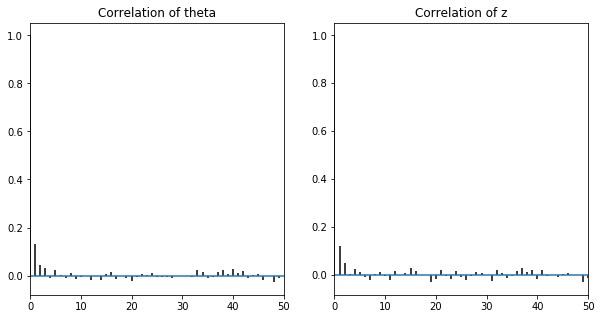

In [12]:
N = 10000
fig,ax = plt.subplots(1,2,figsize=(10,5))
corrplot(theta[N//10::2],ax[0])
corrplot(z[N//10::2],ax[1])
ax[0].set_title('Correlation of theta')
ax[1].set_title('Correlation of z')

C:\Users\Shaan Desai\Anaconda3\envs\am207\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


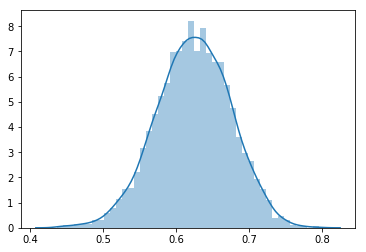

In [17]:
import seaborn as sns
sns.distplot(theta[N//10::2]);

In [21]:
print('probability of getting a 4th type of flower = %s ' %(np.mean(theta[N//10::2])/4))

probability of getting a 4th type of flower = 0.15594353241049208 


## Problem 2. Finding the MLE using Expectation Maximization

Treat the augmented model as a latent variable model. 

### Part A. 

Write down an expression (up to unimportant constants - you must decide what unimportant means) for each of the following:

(1) the observed data log likelihood

(2) the complete(full) data log likelihood

**Hint:** You should already have the observed data likelihood and the complete data likelihood from Problem 1, you just need to take their logs for this problem.

(3) the Auxilary function, $Q(\theta, \theta^{(t-1)})$, or the expected complete(full) data log likelihood, defined by
$$Q(\theta, \theta^{(t-1)}) = \mathbb{E}_{Z  \vert  Y=y, \Theta = \theta^{t-1}}[\text{the complete data log likelihood}]$$

In other words $Z  \vert  Y=y, \Theta = \theta^{t-1}$ is $q(z, \theta_{old})$ from lecture at the end of the E-step and $Q$ is the z-posterior expectation (at $\theta_{old}$) of the full data log likelihood, which is the ELBO minus the entropy of $q$ (which being evaluated at $\theta_{old}$ is not dependent on $\theta$ and thus irrelevant for maximization).

### Part B:

We will maximize the likelihood through Expectation Maximization (EM). In order to preform EM, we must iterate through the following steps

- (Expectation) Compute the Auxilary function, $Q(\theta, \theta^{t-1})$ (the expectation of the full data likelihood)
- (Maximization) Compute $\theta^{t} = \text{argmax}_\theta Q(\theta, \theta^{(t-1)})$

Thus, you must compute exact formulae for the following:
1. the Auxilary function, $Q(\theta, \theta^{(t-1)})$, for a given $\theta^{(t-1)}$. That is, compute the expectation of the complete data log likelihood.
2. $\theta^{t}$, by maximizing the Auxilary function $Q(\theta, \theta^{(t-1)})$.

**Hint:** You don't actually need to do any difficult optimization for the M-step. After taking the expectation of the complete data log likelihood in the E-step, match your $Q(\theta, \theta^{(t-1)})$ to the log pdf of a familiar distribution, then use the known formula for the mode of this distribution to optimize $Q(\theta, \theta^{(t-1)})$.

Use these to **estimate the MLE** of $\theta$ using EM (choose your own reasonable criterion for convergence).

#### Part A

i)
$$ p(y  \vert  \theta) \propto (2+\theta)^{y_1} (1-\theta)^{y_2+y_3}  \, \theta^{y_4} $$

Thus the log likelihood is:

$$ log(p(y\vert \theta)) \propto y_1 log(2+\theta) + (y_2+y_3) log(1-\theta) + y_4 log(\theta) $$
 

ii)

$$ p(y, z  \vert  \theta) \propto \binom{y_{1}}{z} \left (\frac{1}{2} \right )^{y_1-z} \left(\frac{\theta}{4} \right )^{z}  (1-\theta)^{y_2+y_3}  \, \theta^{y_4}
$$



$$ log(p(y,z|\theta)) \propto log({y_1 \choose z}) + (y_1 -z)*log(1/2) + z log(\theta/4) + (y_2 + y_3) log(1-\theta) + y_4 log(\theta) $$ 

iii)

$$ Q(\theta,\theta_{old}) = E_q (full likelihood) = E_q(log({y_1 \choose z})) + y_1*log(1/2) - E_q(z)log(1/2) + E_q(z)log(\theta/4) + (y_2 + y_3) log(1-\theta) + y_4 log(\theta) $$

where 

$$q =  p(z|y,\theta_{old})$$

and where

$$ E_q(z) = n*p $$

since $$ p(z|y,\theta_{old}) $$ is binomial

#### Part B

$$ dQ/d\theta = E_q(z)*1/\theta - (y_2 + y_3)/(1-\theta) + y_4/\theta = 0 $$

Thus:
    
$$ \theta = \frac{E_q(z) + y_4}{E_q(z) + y_2 + y_3 + y_4} $$

from wolfram alpha

where $$ E_q(z) = \frac{y_1 \theta}{2+\theta} $$

In [4]:
def new_theta_fun(ez):
    return (ez + y4)/(ez+y2+y3+y4)

In [5]:
def ez_val(theta):
    return (y1*theta)/(2+theta)

In [12]:
new_theta = 10000
itern = 0
while np.abs(old_theta-new_theta) > 10**(-15):
    if itern == 0:
        old_theta = 0.2
    else:
        old_theta = new_theta
    ez = ez_val(old_theta)
    new_theta = new_theta_fun(ez)
    itern+=1
    

In [14]:
print('probability of getting a 4th type of flower = %s ' %(new_theta/4))

probability of getting a 4th type of flower = 0.15670537446774557 
